### Qiskit Primitives
In order to measure a quantum system, qiskit has 2 primitives:
1. Sampler: Given a quantum state $\ket{\psi}$, the sampler obtains the probability of each possible computational basis state

2. Estimator: Given a quantum observable, and a state, estimator computes the expected value of the observable.

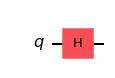

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()

    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw('mpl')

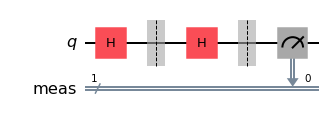

In [2]:
aux_circuits[0].draw('mpl')

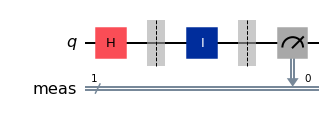

In [3]:
aux_circuits[1].draw('mpl')

In [5]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import IGate, XGate, YGate, ZGate
import numpy as np

shots = 1000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots = shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})



In [7]:
expvals = []
for pauli in H.paulis:
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real

    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)

    if str(pauli) == "Y":
        Lambda = YGate().to_matrix().real
        val += Lambda[0][1] *1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)
    
    expvals.append(val)

In [8]:
print("sampler results")
for (pauli, expval) in zip (H.paulis, expvals):
    print(f"Expected value of {str(pauli)}: {expval:.5f}")

sampler results
Expected value of X: 1.00000
Expected value of Z: 0.04400


In [9]:
total_expval = np.sum(H.coeffs * expvals).real
print(f"Total excpected value = {total_expval:.5f}")

Total excpected value = 1.95600


In [11]:
observables = [
    *H.paulis, H
]

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs


print("estimator results")

for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"expected value of {str(obs)} = {expval:.5f}")
    else:
        print(f"Total value is {expval:.5f}")

estimator results
expected value of X = 1.00000
expected value of Z = 0.00000
Total value is 2.00000
